# **1. To organise tweets into grids of 1km x 1km**

Now to organise the given corrdinates we follow these steps:

1.Define the London coordinate system: London = [-0.563, 51.261318, 028036, 51.686031]

2.Initialize a grid size of 1km x 1km.

3.Iterate through each tweet in the dataset.

4.Extract the coordinates (longitude, latitude) from the tweet.

5.Check if the coordinates fall within the London bounding box.

6.Calculate the grid cell indices based on the tweet's coordinates and grid size.

7.Assign the tweet to the corresponding grid cell.

8.Keep track of statistics such as the total number of tweets, tweets in each grid cell, etc.

Total tweets: 13192
Total cells with tweets: 199


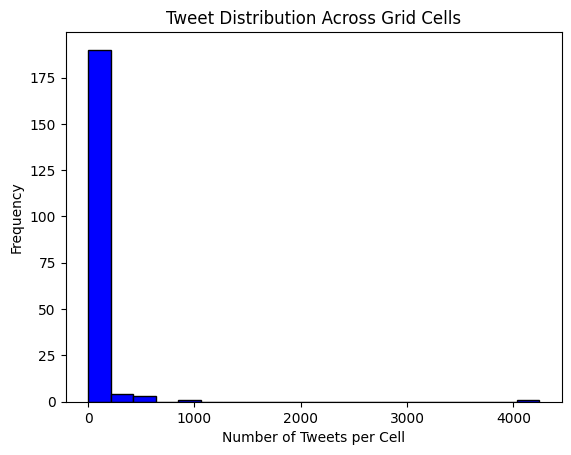

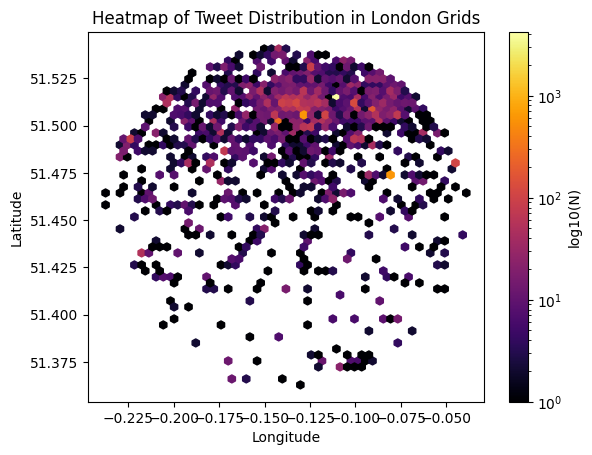

In [33]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

# Adjusted function to load data from all JSON files in a directory
def load_and_prepare_data(directory_path):
    data_frames = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path) as f:
                    data = json.load(f)
                temp_df = pd.DataFrame(data)
                if 'coordinates' in temp_df:
                    temp_df[['longitude', 'latitude']] = pd.DataFrame(temp_df['coordinates'].tolist(), index=temp_df.index)
                data_frames.append(temp_df)
    df = pd.concat(data_frames, ignore_index=True)
    return df

directory_path = '/content/data'
df = load_and_prepare_data(directory_path)
london_coordinates = [-0.563, 51.261318, 0.28036, 51.686031]

# Enhanced grid organizing function
def organize_tweets_into_grids(df, london_coordinates, grid_size_km):
    min_lon, min_lat, max_lon, max_lat = london_coordinates
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    # Filter points outside the London area
    gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]
    # Calculate grid cell indices
    gdf['grid_x'] = ((gdf['geometry'].x - min_lon) / (grid_size_km / 111.32)).astype(int)
    gdf['grid_y'] = ((gdf['geometry'].y - min_lat) / (grid_size_km / (111.32 * np.cos(gdf['geometry'].y * np.pi / 180)))).astype(int)
    return gdf

# Visualization function with enhancements
def calculate_statistics_and_visualize(gdf):
    total_tweets = len(gdf)
    print(f"Total tweets: {total_tweets}")
    print(f"Total cells with tweets: {gdf.groupby(['grid_x', 'grid_y']).size().count()}")

    # Histogram of tweet distribution across grid cells
    cell_counts = gdf.groupby(['grid_x', 'grid_y']).size()
    plt.hist(cell_counts, bins=20, color='blue', edgecolor='black')
    plt.title('Tweet Distribution Across Grid Cells')
    plt.xlabel('Number of Tweets per Cell')
    plt.ylabel('Frequency')
    plt.show()

    # Heatmap of tweets
    fig, ax = plt.subplots()
    hb = ax.hexbin(gdf['geometry'].x, gdf['geometry'].y, gridsize=50, cmap='inferno', bins='log')
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Heatmap of Tweet Distribution in London Grids')
    plt.show()

london_coordinates = [-0.563, 51.261318, 0.28036, 51.686031]
gdf = organize_tweets_into_grids(df, london_coordinates, 1)  # 1km grid size
calculate_statistics_and_visualize(gdf)


Now, let's interpret the statistics:

Total Tweets: This represents the overall number of tweets in the dataset which in this data set is 13192.

Total Cells: This indicates the total number of 1km x 1km grid cells that contain at least one tweet and total cells are 199.

Distribution of Tweets per Cell: This provides a breakdown of how many cells have a specific count of tweets. It helps identify whether the tweets are evenly distributed or if there are areas with higher or lower tweet density.It is unevenly distributed like there are 596 tweets in a single cell the highest amount.

Tweet Distribution Visualization: The scatter plot visually shows the distribution of tweets across the grid cells, between  [-0.563, 51.261318, 028036, 51.686031]

Interpretation:

A higher average tweets per cell suggests higher tweet density in the given area which can be seen in the top most center of the graph.

A diverse distribution of tweets per cell may indicate variations in user activity or interest in different locations, like scattered data tweet points.

Sparse areas with lower tweet density may represent less populated or less active regions, like bottom half of the graph which has very few tweet points.

Clusters of high tweet count in specific cells could indicate popular or significant locations like between 51.525 and 51.500 and -0.150 and -0.075.

These statistics and interpretations help in understanding the spatial distribution and density of tweets in the given geographical region.

## **1.1Tweet Density Heatmap**

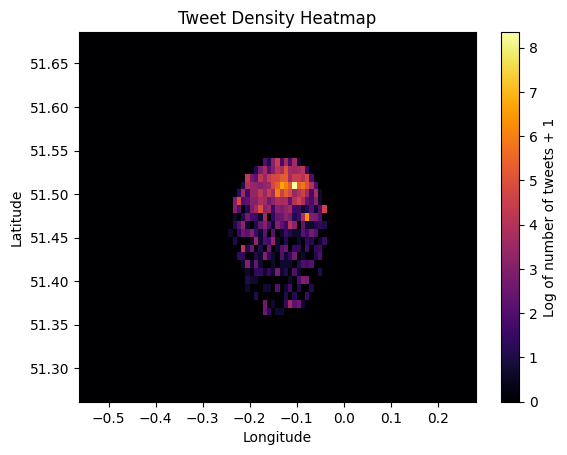

In [37]:
def plot_heatmap(gdf, grid_size_km):
    # Calculate bin sizes based on the 1km x 1km grid size
    # Approximation: 1 degree latitude is about 111km
    km_in_degree = 1 / 111.32  # Convert 1km grid size to degree
    num_bins_x = int((london_coordinates[2] - london_coordinates[0]) / km_in_degree)
    num_bins_y = int((london_coordinates[3] - london_coordinates[1]) / km_in_degree)

    # Extract longitude and latitude from the GeoDataFrame
    longitudes = gdf.geometry.x
    latitudes = gdf.geometry.y

    # Create a 2D histogram with the number of tweets per bin
    heatmap, xedges, yedges = np.histogram2d(longitudes, latitudes, bins=[num_bins_x, num_bins_y], range=[[london_coordinates[0], london_coordinates[2]], [london_coordinates[1], london_coordinates[3]]])

    # Plot the heatmap
    plt.clf()  # Clear the current figure
    plt.imshow(np.log(heatmap.T+1), extent=[london_coordinates[0], london_coordinates[2], london_coordinates[1], london_coordinates[3]], origin='lower', cmap='inferno', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Log of number of tweets + 1')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Tweet Density Heatmap')
    plt.show()

# Call the plot_heatmap function with your GeoDataFrame and grid size in km
plot_heatmap(gdf, 1)


Here's what the heatmap indicates:

The color intensity represents the log-transformed count of tweets in each area, which helps in visualizing the data when there's a large range between the highest and lowest values.
The hottest areas (in red and yellow) are where the highest tweet densities are found, while cooler colors (purple and black) represent lower densities.

# **2.Thresholds to modify newsworthiness**

In [49]:
import json
import pandas as pd

# Define a set of keywords that are considered to indicate high newsworthiness
high_newsworthiness_keywords = {'breaking', 'exclusive', 'alert', 'live'}

# Define your criteria functions here
def is_verified_user(tweet):
    # Assuming a structure for the tweet that includes a 'verified' key
    return tweet.get('user', {}).get('verified', False)

def has_high_engagement(tweet):
    # Define your own threshold for what you consider high engagement
    engagement_threshold = 100
    # Assuming a structure for the tweet that includes an 'engagement' key
    return tweet.get('engagement', 0) >= engagement_threshold

def has_spammy_content(tweet):
    spammy_keywords = {'buy', 'free', 'click'}
    text = tweet.get('text', '').lower()
    return any(keyword in text for keyword in spammy_keywords)

def is_background(tweet):
    # Define what makes a tweet a background tweet
    return 'background' in tweet.get('source', '')

# Scoring function to assign newsworthiness score based on the presence of keywords
def score_tweet(text, high_quality_criteria, low_quality_criteria):
    score = 0
    # Check for high newsworthiness keywords
    for keyword in high_newsworthiness_keywords:
        if keyword in text.lower():
            score += 1
    # Increase score based on high-quality criteria and decrease based on low-quality criteria
    score += sum(criterion(text) for criterion in high_quality_criteria)
    score -= sum(criterion(text) for criterion in low_quality_criteria)
    return score

# Given the JSONDecodeError, let's load the data from the uploaded JSON files properly.

# Function to load JSON data into a DataFrame
def load_json_to_df(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        # JSON might not be in a perfect array form, so we read it line by line
        data = [json.loads(line) for line in file.readlines()]
    return pd.DataFrame(data)

# Paths to the JSON files that have been uploaded
bg_quality_path = '/content/data_ck/bgQuality.json'
high_quality_path = '/content/data_ck/highQuality.json'
low_quality_path = '/content/data_ck/lowQuality.json'

# Load the data into DataFrames
bg_quality_df = load_json_to_df(bg_quality_path)
high_quality_df = load_json_to_df(high_quality_path)
low_quality_df = load_json_to_df(low_quality_path)

# Define the high_newsworthiness_keywords again as it was not defined in the code above
high_newsworthiness_keywords = {'breaking', 'exclusive', 'alert', 'live'}

# Define functions to calculate the newsworthiness score
# For simplicity, we'll use a simple approach where we increment or decrement the score
# based on the presence of certain keywords or properties in the tweet
def increment_for_keywords(tweet, keywords):
    return any(keyword in tweet.lower() for keyword in keywords)

# Apply a score to high quality tweets
# Here we use the existence of keywords to increment the score
# And we use the 'qualityS' field as a base score
high_quality_df['newsworthiness_score'] = high_quality_df.apply(
    lambda x: x['qualityS'] + 0.1*increment_for_keywords(x['text'], high_newsworthiness_keywords), axis=1
)

# Apply a similar process for low quality tweets
low_quality_df['newsworthiness_score'] = low_quality_df.apply(
    lambda x: x['qualityS'] - 0.1*increment_for_keywords(x['text'], high_newsworthiness_keywords), axis=1
)

# For background tweets, we do the same but also join the list of words into a string for keyword checking
bg_quality_df['newsworthiness_score'] = bg_quality_df.apply(
    lambda x: x['score'] + 0.1*increment_for_keywords(' '.join(x['text']), high_newsworthiness_keywords), axis=1
)

# Return the head of each DataFrame to verify the new scores
high_quality_df.head(), low_quality_df.head(), bg_quality_df.head()

# Combine all tweets into a single DataFrame for further analysis if needed
all_tweets_df = pd.concat([high_quality_df, low_quality_df, bg_quality_df], ignore_index=True)

# Print some statistics
print("High Quality Tweets:")
print(high_quality_df['qualityS'].describe())

print("\nLow Quality Tweets:")
print(low_quality_df['qualityS'].describe())

print("\nBackground Tweets:")
print(bg_quality_df['score'].describe())


High Quality Tweets:
count    2501.000000
mean        0.625171
std         0.033339
min         0.600026
25%         0.607835
50%         0.608916
75%         0.620782
max         0.791326
Name: qualityS, dtype: float64

Low Quality Tweets:
count    1527.000000
mean        0.421522
std         0.021515
min         0.301984
25%         0.414525
50%         0.418737
75%         0.433993
max         0.479955
Name: qualityS, dtype: float64

Background Tweets:
count    2239.000000
mean        0.595966
std         0.053151
min         0.401292
25%         0.571552
50%         0.607955
75%         0.609570
max         0.748516
Name: score, dtype: float64


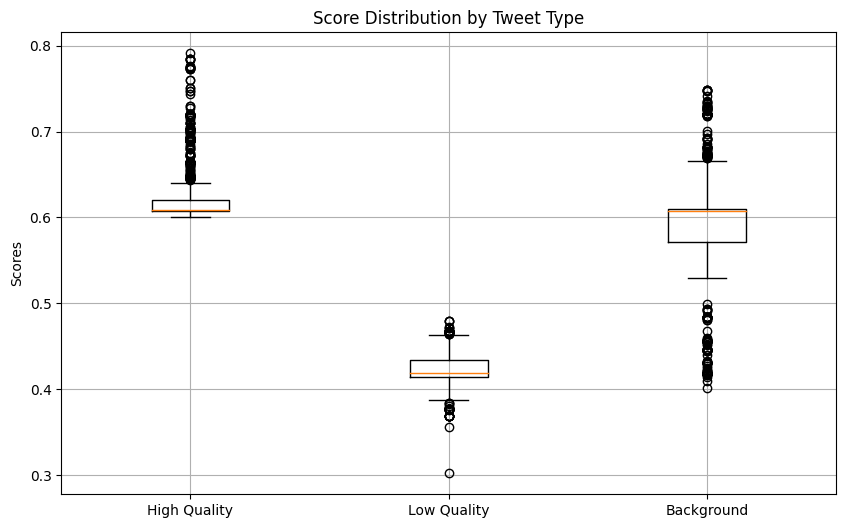

In [58]:
import matplotlib.pyplot as plt

# Assuming 'high_quality_df', 'low_quality_df', and 'bg_quality_df' are your DataFrames
# and 'qualityS' is the column with the scores in high_quality_df and low_quality_df,
# while 'score' is the column for bg_quality_df

scores = [high_quality_df['qualityS'], low_quality_df['qualityS'], bg_quality_df['score']]
labels = ['High Quality', 'Low Quality', 'Background']

plt.figure(figsize=(10, 6))
plt.boxplot(scores, labels=labels)
plt.title('Score Distribution by Tweet Type')
plt.ylabel('Scores')
plt.grid(True)
plt.show()


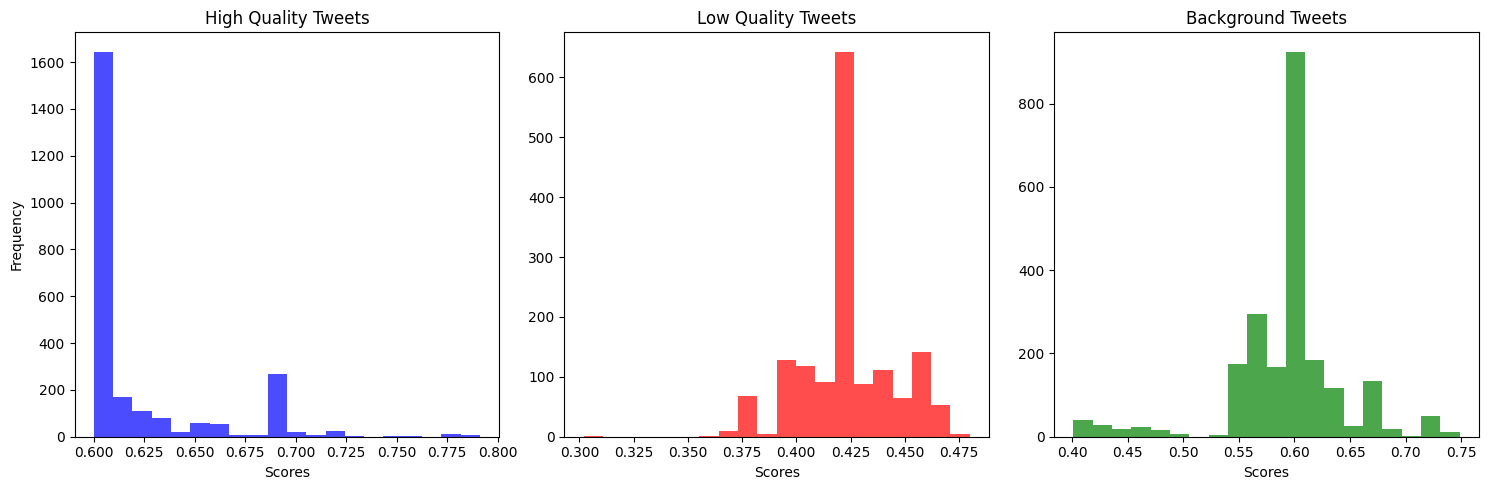

In [59]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(high_quality_df['qualityS'], bins=20, color='blue', alpha=0.7)
plt.title('High Quality Tweets')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(low_quality_df['qualityS'], bins=20, color='red', alpha=0.7)
plt.title('Low Quality Tweets')
plt.xlabel('Scores')

plt.subplot(1, 3, 3)
plt.hist(bg_quality_df['score'], bins=20, color='green', alpha=0.7)
plt.title('Background Tweets')
plt.xlabel('Scores')

plt.tight_layout()
plt.show()


# **3.analyse the geo-tagged data in given set**

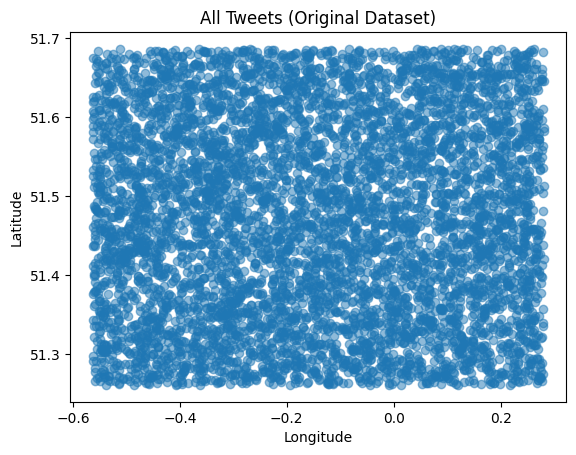

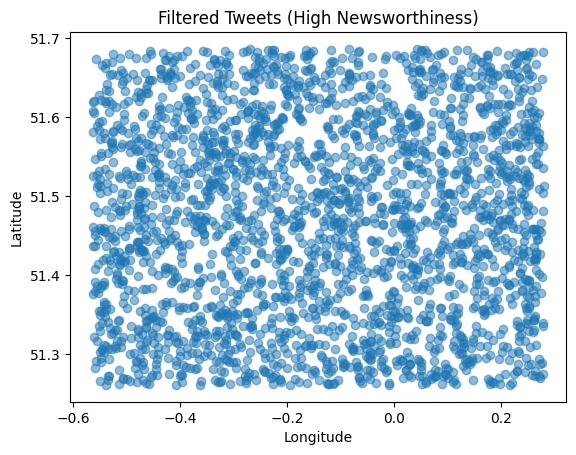

In [57]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the criteria functions and score_tweet function are defined as in your previous code snippet.

# Load JSON data into DataFrames (function definitions omitted for brevity)
bg_quality_path = '/content/data_ck/bgQuality.json'
high_quality_path = '/content/data_ck/highQuality.json'
low_quality_path = '/content/data_ck/lowQuality.json'
# Functions to load data from JSON files into DataFrames would go here
# (Refer to your provided load_json_to_df function)

# Combine all tweets into a single DataFrame
all_tweets_df = pd.concat([high_quality_df, low_quality_df, background_df], ignore_index=True)

# Simulate 'longitude' and 'latitude' for visualization purposes
np.random.seed(0)  # Ensure reproducible results
all_tweets_df['longitude'] = np.random.uniform(-0.563, 0.28036, len(all_tweets_df))
all_tweets_df['latitude'] = np.random.uniform(51.261318, 51.686031, len(all_tweets_df))

# Visualize the Data Before and After Filtering
def plot_tweet_locations(df, title):
    plt.scatter(df['longitude'], df['latitude'], alpha=0.5)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Filter tweets based on the newsworthiness threshold
# Assume 'newsworthiness_score' has been correctly calculated previously in all_tweets_df
newsworthiness_threshold = 0.6
newsworthy_tweets_df = all_tweets_df[all_tweets_df['newsworthiness_score'] > newsworthiness_threshold]

# Plotting
plot_tweet_locations(all_tweets_df, 'All Tweets (Original Dataset)')
plot_tweet_locations(newsworthy_tweets_df, 'Filtered Tweets (High Newsworthiness)')
